In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import os
from collections import Counter
import glob
import gc  # For garbage collection

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure TensorFlow for memory optimization
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory configuration error: {e}")

2025-05-26 12:03:57.901947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748261038.134333     118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748261038.201044     118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class AnimalCNNClassifier:
    def __init__(self, input_shape=(224, 224, 3), num_classes=3):
        """
        Initialize CNN classifier for animal images

        Args:
            input_shape: Shape of input images (height, width, channels)
            num_classes: Number of classes (dog, spider, elephant)
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.class_names = ['dog', 'spider', 'elephant']
        self.model = None
        self.history = None

    def build_model(self):
        """
        Build CNN architecture optimized for animal classification with reduced parameters
        """
        model = keras.Sequential([
            # First Convolutional Block - Reduced filters
            layers.Conv2D(16, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second Convolutional Block
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third Convolutional Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fourth Convolutional Block - Reduced filters
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Global Average Pooling (reduces parameters significantly)
            layers.GlobalAveragePooling2D(),

            # Dense Layers - Reduced size
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # Output Layer
            layers.Dense(self.num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def get_model_summary(self):
        """Print model architecture summary"""
        if self.model is None:
            self.build_model()
        return self.model.summary()

    def prepare_data_with_gan(self, X_real, y_real, X_fake_elephant, test_size=0.2, val_size=0.25, max_fake_elephant=2000):
        """
        Prepare and split data for training with GAN-generated elephant images
        Fake images are ONLY added to the training set

        Args:
            X_real: Real input images
            y_real: Real labels
            X_fake_elephant: Fake elephant images generated by GAN
            test_size: Proportion for test set (20% of total real data)
            val_size: Proportion for validation set (20% of total real data)
            max_fake_elephant: Maximum number of fake elephant images to use

        Returns:
            Split datasets: X_train, X_val, X_test, y_train, y_val, y_test
        """
        print("Preparing data splits with GAN-generated elephant images...")
        print(f"Real dataset size: {len(X_real)} samples")
        print(f"Fake elephant images available: {len(X_fake_elephant)} samples")

        # Check original class distribution
        unique_classes, counts = np.unique(y_real, return_counts=True)
        print("\nOriginal real data class distribution:")
        for i, class_name in enumerate(self.class_names):
            if i in unique_classes:
                count = counts[list(unique_classes).index(i)]
                percentage = (count / len(y_real)) * 100
                print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

        # First split: separate test set from REAL data only (20% of real data)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_real, y_real,
            test_size=test_size,
            random_state=42,
            stratify=y_real
        )

        # Second split: separate train and validation from remaining REAL data
        X_train_real, X_val, y_train_real, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size,
            random_state=42,
            stratify=y_temp
        )

        # Cap fake elephant samples and free memory
        if len(X_fake_elephant) > max_fake_elephant:
            print(f"\nCapping fake elephant images to {max_fake_elephant} out of {len(X_fake_elephant)} available")
            # Randomly sample to avoid bias
            indices = np.random.choice(len(X_fake_elephant), max_fake_elephant, replace=False)
            X_fake_elephant_capped = X_fake_elephant[indices].copy()
            # Delete original to free memory
            del X_fake_elephant
            gc.collect()
            X_fake_elephant = X_fake_elephant_capped
        else:
            print(f"\nUsing all {len(X_fake_elephant)} fake elephant images (no cap needed)")

        # Create labels for fake elephant images (class 2 = elephant)
        y_fake_elephant = np.full(len(X_fake_elephant), 2)  # 2 is elephant class index

        # Combine real training data with fake elephant data
        X_train = np.concatenate([X_train_real, X_fake_elephant], axis=0)
        y_train = np.concatenate([y_train_real, y_fake_elephant], axis=0)

        # Clean up intermediate variables
        del X_train_real, y_fake_elephant
        gc.collect()

        # Shuffle the training data
        shuffle_indices = np.random.permutation(len(X_train))
        X_train = X_train[shuffle_indices]
        y_train = y_train[shuffle_indices]

        print(f"\nData split completed:")
        print(f"  Training set: {len(X_train)} samples ({len(y_train_real)} real + {len(X_fake_elephant)} fake)")
        print(f"  Validation set: {len(X_val)} samples (real only)")
        print(f"  Test set: {len(X_test)} samples (real only)")

        # Normalize pixel values to [0, 1] - do this in-place to save memory
        print("Normalizing pixel values...")
        X_train = X_train.astype('float32')
        X_train /= 255.0
        X_val = X_val.astype('float32')
        X_val /= 255.0
        X_test = X_test.astype('float32')
        X_test /= 255.0

        # Show final class distribution in training set
        print("\nFinal training set class distribution (including fake data):")
        unique, counts = np.unique(y_train, return_counts=True)
        for i, class_name in enumerate(self.class_names):
            if i in unique:
                count = counts[list(unique).index(i)]
                percentage = (count / len(y_train)) * 100
                if i == 2:  # Elephant class
                    real_count = Counter(y_train_real).get(i, 0)
                    fake_count = count - real_count
                    print(f"  {class_name}: {count} samples ({percentage:.1f}%) [{real_count} real + {fake_count} fake]")
                else:
                    print(f"  {class_name}: {count} samples ({percentage:.1f}%) [all real]")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def analyze_class_distribution_with_gan(self, y_train, y_val, y_test, y_train_real, num_fake_elephant):
        """
        Analyze and visualize class distribution including GAN-generated data
        """
        train_counts = Counter(y_train)
        train_real_counts = Counter(y_train_real)
        val_counts = Counter(y_val)
        test_counts = Counter(y_test)

        print("Class Distribution Analysis (with GAN data):")
        print("=" * 60)
        print(f"Training set (real + fake):")
        for i, class_name in enumerate(self.class_names):
            count = train_counts.get(i, 0)
            real_count = train_real_counts.get(i, 0)
            fake_count = count - real_count if i == 2 else 0  # Only elephant has fake data
            percentage = (count / len(y_train)) * 100
            if fake_count > 0:
                print(f"  {class_name}: {count} samples ({percentage:.1f}%) [{real_count} real + {fake_count} fake]")
            else:
                print(f"  {class_name}: {count} samples ({percentage:.1f}%) [all real]")

        # Create a more memory-efficient plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Training set with real/fake breakdown
        real_counts = [train_real_counts.get(i, 0) for i in range(self.num_classes)]
        fake_counts = [min(num_fake_elephant, 2000) if i == 2 else 0 for i in range(self.num_classes)]

        x = np.arange(len(self.class_names))
        width = 0.35

        axes[0].bar(x, real_counts, width, label='Real', color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
        axes[0].bar(x, fake_counts, width, bottom=real_counts, label='GAN-generated',
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.4)
        axes[0].set_title('Training Set Distribution\n(Real + GAN-generated)')
        axes[0].set_ylabel('Number of Samples')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(self.class_names)
        axes[0].legend()

        # Validation set
        val_counts_list = [val_counts.get(i, 0) for i in range(self.num_classes)]
        axes[1].bar(self.class_names, val_counts_list, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[1].set_title('Validation Set Distribution\n(Real only)')
        axes[1].set_ylabel('Number of Samples')

        # Test set
        test_counts_list = [test_counts.get(i, 0) for i in range(self.num_classes)]
        axes[2].bar(self.class_names, test_counts_list, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[2].set_title('Test Set Distribution\n(Real only)')
        axes[2].set_ylabel('Number of Samples')

        plt.tight_layout()
        plt.show()
        plt.close()  # Close to free memory

    def train_model(self, X_train, y_train, X_val, y_val, epochs=30, batch_size=16):
        """
        Train the CNN model with reduced batch size for memory efficiency
        """
        if self.model is None:
            self.build_model()

        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=8,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=4,
                min_lr=0.0001
            ),
            # Add memory cleanup callback
            keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: gc.collect()
            )
        ]

        # Train model with reduced batch size
        print("Starting training...")
        self.history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,  # Reduced from 32 to 16
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def plot_training_history(self):
        """
        Plot training and validation metrics
        """
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        plt.close()  # Close to free memory

    def evaluate_model(self, X_test, y_test):
        """
        Comprehensive model evaluation with all required metrics
        """
        if self.model is None:
            print("Model not trained yet!")
            return

        # Get predictions in batches to save memory
        batch_size = 32
        y_pred_proba = []
        
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i:i+batch_size]
            batch_pred = self.model.predict(batch, verbose=0)
            y_pred_proba.append(batch_pred)
        
        y_pred_proba = np.vstack(y_pred_proba)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Basic metrics
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)

        print("Model Evaluation Results:")
        print("=" * 50)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=self.class_names))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        self.plot_confusion_matrix(cm)

        # ROC Curves and AUC
        self.plot_roc_curves(y_test, y_pred_proba)

        return {
            'accuracy': test_accuracy,
            'loss': test_loss,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': cm
        }

    def plot_confusion_matrix(self, cm):
        """
        Plot confusion matrix
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        plt.close()  # Close to free memory

    def plot_roc_curves(self, y_test, y_pred_proba):
        """
        Plot ROC curves for each class and calculate AUC
        """
        # Binarize the output
        y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

        plt.figure(figsize=(10, 8))

        colors = ['red', 'green', 'blue']
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=colors[i], lw=2,
                    label=f'{self.class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
        plt.close()  # Close to free memory

    def predict_sample_images(self, X_test, y_test, num_samples=9):
        """
        Display sample predictions with confidence scores
        """
        if self.model is None:
            print("Model not trained yet!")
            return

        # Randomly select samples
        indices = np.random.choice(len(X_test), num_samples, replace=False)
        sample_images = X_test[indices]
        sample_labels = y_test[indices]

        # Get predictions
        predictions = self.model.predict(sample_images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)

        # Plot results
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        axes = axes.ravel()

        for i in range(num_samples):
            axes[i].imshow(sample_images[i])

            true_label = self.class_names[sample_labels[i]]
            pred_label = self.class_names[predicted_classes[i]]
            confidence = predictions[i][predicted_classes[i]] * 100

            color = 'green' if predicted_classes[i] == sample_labels[i] else 'red'
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                            color=color)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Close to free memory


In [3]:
# Memory-optimized data loading function
def load_animal_data_with_gan(data_path='/kaggle/input/animals/animals',
                             fake_elephant_path='/kaggle/input/animals/animals/VanillaGANelephant(2)',
                             max_fake_elephant=2000):
    """
    Load real animal images and fake elephant images generated by GAN with memory optimization

    Expected structure:
    /content/drive/MyDrive/animals/
    ├── dog/ (jpg files)
    ├── spider/ (jpg files)
    ├── elephant/ (jpg files - real)
    └── elephant_fake/ (png files - GAN generated, capped at max_fake_elephant)
    """
    from tensorflow.keras.preprocessing import image

    print(f"Loading real data from: {data_path}")
    print(f"Loading fake elephant data from: {fake_elephant_path}")
    print(f"Maximum fake elephant images to load: {max_fake_elephant}")


    # Check if paths exist
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Real data path {data_path} does not exist!")

    if not os.path.exists(fake_elephant_path):
        raise FileNotFoundError(f"Fake elephant data path {fake_elephant_path} does not exist!")

    # Define class mapping
    class_names = ['dog', 'spider', 'elephant']
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    # Load real images
    real_images = []
    real_labels = []
    class_counts = {}

    print("Loading real images...")
    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)

        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist! Skipping {class_name}")
            continue

        # Get all jpg/jpeg image files for real data
        image_extensions = ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG']
        image_files = []
        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(class_path, ext)))

        print(f"Found {len(image_files)} real {class_name} images")
        class_counts[f'{class_name}_real'] = len(image_files)

        for img_path in image_files:
            try:
                # Load and preprocess image
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)

                real_images.append(img_array)
                real_labels.append(class_to_idx[class_name])

            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")
                continue

    # Load fake elephant images with cap
    print("Loading fake elephant images...")
    fake_elephant_images = []

    # Get all png image files for fake data
    fake_image_extensions = ['*.png', '*.PNG']
    fake_image_files = []
    for ext in fake_image_extensions:
        fake_image_files.extend(glob.glob(os.path.join(fake_elephant_path, ext)))

    print(f"Found {len(fake_image_files)} fake elephant images")
    
    # Apply cap during loading to save memory
    if len(fake_image_files) > max_fake_elephant:
        print(f"Randomly selecting {max_fake_elephant} out of {len(fake_image_files)} fake images")
        fake_image_files = np.random.choice(fake_image_files, max_fake_elephant, replace=False).tolist()
    
    class_counts['elephant_fake'] = len(fake_image_files)

    for img_path in fake_image_files:
        try:
            # Load and preprocess image
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)

            fake_elephant_images.append(img_array)

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            continue

    # Convert to numpy arrays
    X_real = np.array(real_images, dtype=np.uint8)  # Use uint8 to save memory
    y_real = np.array(real_labels)
    X_fake_elephant = np.array(fake_elephant_images, dtype=np.uint8)  # Use uint8 to save memory

    # Clean up intermediate lists
    del real_images, fake_elephant_images
    gc.collect()

    print(f"\nDataset loaded successfully!")
    print(f"Real images: {len(X_real)}")
    print(f"Fake elephant images: {len(X_fake_elephant)} (capped at {max_fake_elephant})")
    print(f"Real image shape: {X_real.shape}")
    print(f"Fake image shape: {X_fake_elephant.shape}")

    print(f"\nReal data class distribution:")
    for class_name in class_names:
        count = class_counts.get(f'{class_name}_real', 0)
        percentage = (count / len(y_real)) * 100 if len(y_real) > 0 else 0
        print(f"  {class_name}: {count} images ({percentage:.1f}%)")

    print(f"\nFake data:")
    print(f"  elephant (fake): {class_counts.get('elephant_fake', 0)} images")

    return X_real, y_real, X_fake_elephant, class_counts

def verify_data_structure_with_gan(data_path='/content/drive/MyDrive/

In [4]:
def verify_data_structure_with_gan(data_path='/kaggle/input/animals/animals',
                                  fake_elephant_path='/kaggle/input/animals/animals/VanillaGANelephant(2)'):
    """
    Verify the data directory structure including fake elephant images
    """
    print("Verifying data structure...")
    print("=" * 50)

    if not os.path.exists(data_path):
        print(f"❌ Main directory {data_path} does not exist!")
        return False

    print(f"✅ Main directory exists: {data_path}")

    class_names = ['dog', 'spider', 'elephant']
    all_good = True

    # Check real data directories
    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            # Count jpg/jpeg files for real data
            image_extensions = ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG']
            image_count = 0
            for ext in image_extensions:
                image_count += len(glob.glob(os.path.join(class_path, ext)))

            print(f"✅ {class_name}/ directory: {image_count} real images (jpg/jpeg)")
        else:
            print(f"❌ {class_name}/ directory missing!")
            all_good = False

    # Check fake elephant directory
    if os.path.exists(fake_elephant_path):
        # Count png files for fake data
        fake_extensions = ['*.png', '*.PNG']
        fake_count = 0
        for ext in fake_extensions:
            fake_count += len(glob.glob(os.path.join(fake_elephant_path, ext)))

        print(f"✅ elephant_fake/ directory: {fake_count} fake images (png)")
        if fake_count > 2000:
            print(f"  ⚠️ Note: Will cap at 2000 images for memory efficiency")
    else:
        print(f"❌ elephant_fake/ directory missing at {fake_elephant_path}!")
        all_good = False

    return all_good

Starting Animal Classification Training with Vanilla GAN Generated Data
Verifying data structure...
✅ Main directory exists: /kaggle/input/animals/animals
✅ dog/ directory: 4863 real images (jpg/jpeg)
✅ spider/ directory: 4819 real images (jpg/jpeg)
✅ elephant/ directory: 1438 real images (jpg/jpeg)
✅ elephant_fake/ directory: 3417 fake images (png)
  ⚠️ Note: Will cap at 2000 images for memory efficiency
Loading real data from: /kaggle/input/animals/animals
Loading fake elephant data from: /kaggle/input/animals/animals/VanillaGANelephant(2)
Maximum fake elephant images to load: 2000
Loading real images...
Found 4863 real dog images
Found 4819 real spider images
Found 1438 real elephant images
Loading fake elephant images...
Found 3417 fake elephant images
Randomly selecting 2000 out of 3417 fake images

Dataset loaded successfully!
Real images: 11120
Fake elephant images: 2000 (capped at 2000)
Real image shape: (11120, 224, 224, 3)
Fake image shape: (2000, 224, 224, 3)

Real data clas

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748261312.052578     118 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748261312.053255     118 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,0

 Total params: 166,243 (649.39 KB)

 Trainable params: 164,995 (644.51 KB)

 Non-trainable params: 1,248 (4.88 KB)

Preparing data splits with GAN-generated elephant images...
Real dataset size: 11120 samples
Fake elephant images available: 2000 samples

Original real data class distribution:
  dog: 4863 samples (43.7%)
  spider: 4819 samples (43.3%)
  elephant: 1438 samples (12.9%)

Using all 2000 fake elephant images (no cap needed)

Data split completed:
  Training set: 8672 samples (6672 real + 2000 fake)
  Validation set: 2224 samples (real only)
  Test set: 2224 samples (real only)
Normalizing pixel values...

Final training set class distribution (including fake data):
  dog: 2918 samples (33.6%) [all real]
  spider: 2891 samples (33.3%) [all real]
  elephant: 2863 samples (33.0%) [863 real + 2000 fake]
Class Distribution Analysis (with GAN data):
Training set (real + fake):
  dog: 2918 samples (33.6%) [all real]
  spider: 2891 samples (33.3%) [all real]
  elephant: 2863 samples (33.0%) [863 real + 2000 fake]


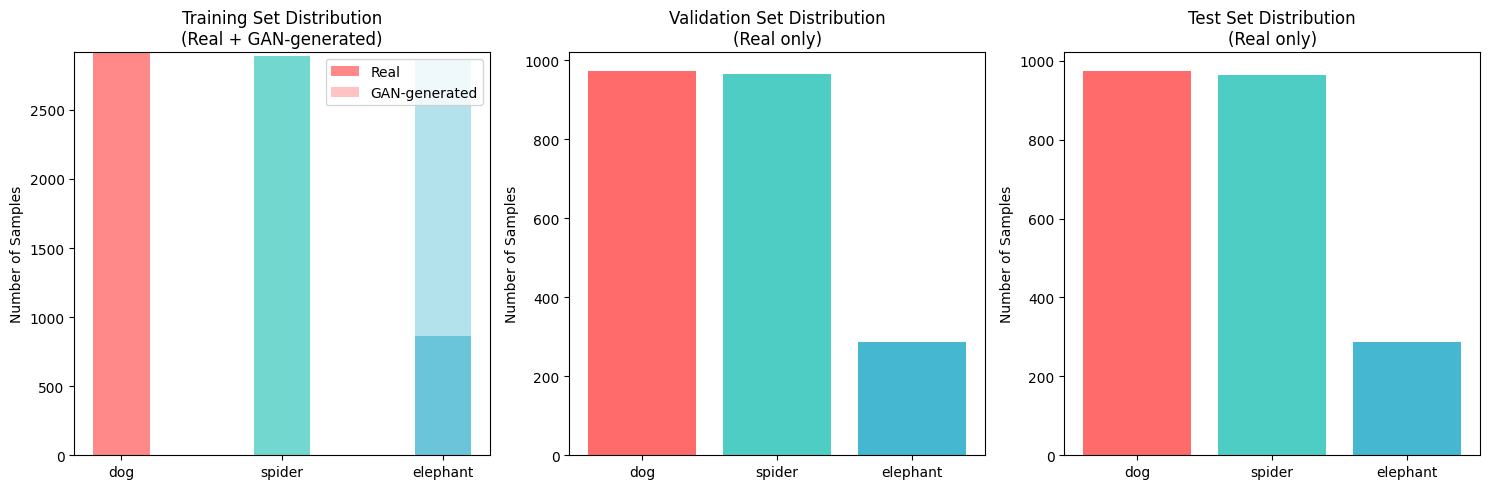


Starting model training with GAN-augmented data...
Starting training...
Epoch 1/30


I0000 00:00:1748261338.686083     155 service.cc:148] XLA service 0x7cbbd0002760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748261338.686991     155 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748261338.687012     155 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748261339.351694     155 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/271 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3576 - loss: 2.1257   

I0000 00:00:1748261347.730010     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


271/271 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.4483 - loss: 1.4695 - val_accuracy: 0.4155 - val_loss: 2.3321 - learning_rate: 0.0010
Epoch 2/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6478 - loss: 0.8271 - val_accuracy: 0.5171 - val_loss: 1.2902 - learning_rate: 0.0010
Epoch 3/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7800 - loss: 0.5333 - val_accuracy: 0.6066 - val_loss: 1.3593 - learning_rate: 0.0010
Epoch 4/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8258 - loss: 0.4320 - val_accuracy: 0.7720 - val_loss: 0.5699 - learning_rate: 0.0010
Epoch 5/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8426 - loss: 0.3984 - val_accuracy: 0.8197 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 6/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8585 - loss: 0.3602 - val_accuracy: 0.5994 - val_loss: 1.3154 - learning_rate: 0.0010
Epoch 7/30
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8704 - loss: 0.3280

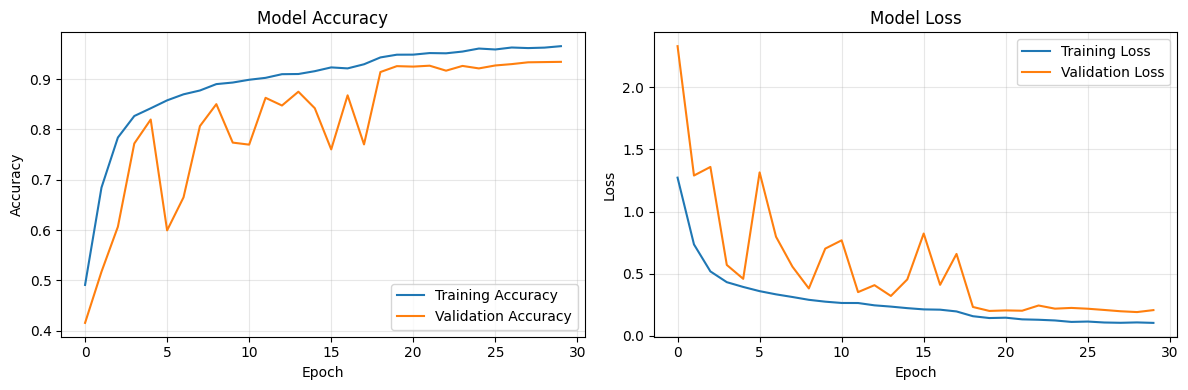


Evaluating model performance...
Model Evaluation Results:
Test Accuracy: 0.9406
Test Loss: 0.1854

Classification Report:
              precision    recall  f1-score   support

         dog       0.96      0.92      0.94       973
      spider       0.95      0.97      0.96       964
    elephant       0.86      0.91      0.88       287

    accuracy                           0.94      2224
   macro avg       0.92      0.93      0.93      2224
weighted avg       0.94      0.94      0.94      2224



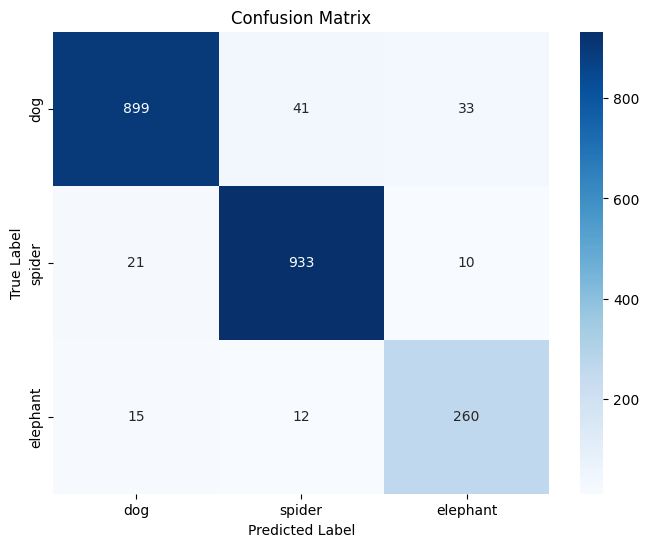

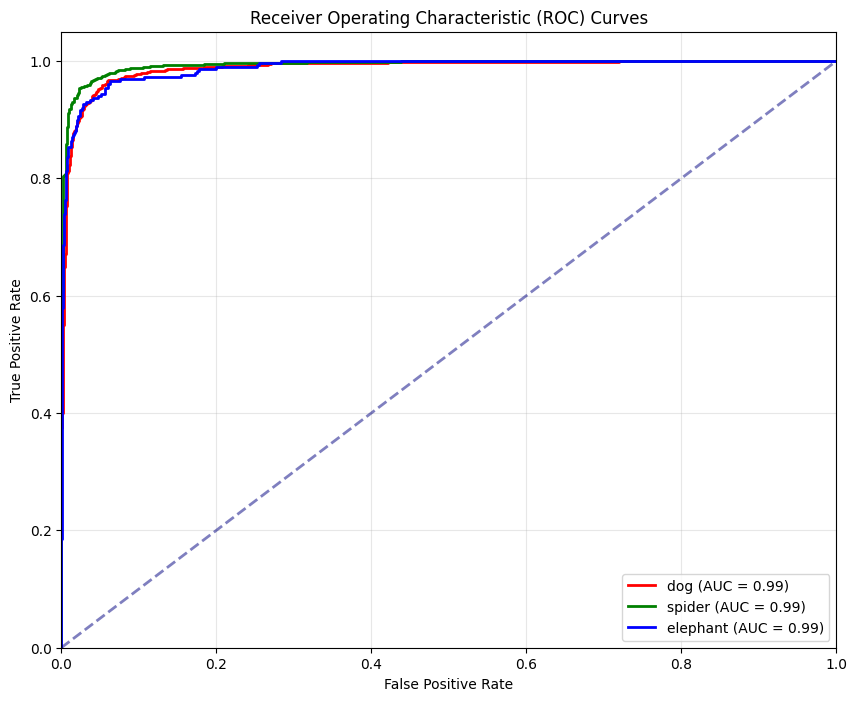


Displaying sample predictions...


In [ ]:
# Main execution
if __name__ == "__main__":
    # Data path configuration
    DATA_PATH = '/kaggle/input/animals/animals'
    FAKE_ELEPHANT_PATH = '/kaggle/input/animals/animals/VanillaGANelephant(2)'

    print("Starting Animal Classification Training with Vanilla GAN Generated Data")
    print("=" * 75)

    # Step 1: Verify data structure
    if not verify_data_structure_with_gan(DATA_PATH, FAKE_ELEPHANT_PATH):
        print("❌ Data structure verification failed!")
        print("Please ensure your data is organized as:")
        print("/content/drive/MyDrive/animals/")
        print("├── dog/ (jpg files)")
        print("├── spider/ (jpg files)")
        print("├── elephant/ (jpg files - real)")
        print("└── elephant_fake/ (png files - GAN generated)")
        exit(1)

    # Step 2: Load data
    try:
        X_real, y_real, X_fake_elephant, class_counts = load_animal_data_with_gan(DATA_PATH, FAKE_ELEPHANT_PATH)
        print(f"✅ Data loaded successfully: {len(X_real)} real + {len(X_fake_elephant)} fake elephant images")
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        exit(1)

    # Step 3: Initialize classifier
    classifier = AnimalCNNClassifier()

    # Step 4: Display model architecture
    print("\nCNN Model Architecture:")
    print("=" * 50)
    classifier.get_model_summary()

    # Step 5: Prepare data with GAN augmentation
    X_train, X_val, X_test, y_train, y_val, y_test = classifier.prepare_data_with_gan(
        X_real, y_real, X_fake_elephant
    )

    # Keep track of real training labels for analysis
    y_train_real_indices = len(y_real) - len(X_test) - len(X_val)  # Approximate real training samples
    X_temp, _, y_temp, _ = train_test_split(X_real, y_real, test_size=0.2, random_state=42, stratify=y_real)
    X_train_real, _, y_train_real, _ = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

    # Step 6: Analyze class distribution
    classifier.analyze_class_distribution_with_gan(y_train, y_val, y_test, y_train_real, len(X_fake_elephant))

    # Step 7: Train model
    print("\nStarting model training with GAN-augmented data...")
    history = classifier.train_model(X_train, y_train, X_val, y_val, epochs=30, batch_size=32)

    # Step 8: Plot training history
    print("\nDisplaying training history...")
    classifier.plot_training_history()

    # Step 9: Evaluate model
    print("\nEvaluating model performance...")
    results = classifier.evaluate_model(X_test, y_test)

    # Step 10: Show sample predictions
    print("\nDisplaying sample predictions...")
    classifier.predict_sample_images(X_test, y_test)

    # Step 11: Compare with baseline (if available)
    print("\n" + "=" * 75)
    print("TRAINING COMPLETED - VANILLA GAN AUGMENTED DATASET RESULTS")
    print("=" * 75)
    print(f"Final Test Accuracy: {results['accuracy']:.4f}")
    print(f"Final Test Loss: {results['loss']:.4f}")

    # Try to load baseline results for comparison
    try:
        import pickle
        with open('/content/baseline_results.pkl', 'rb') as f:
            baseline_results = pickle.load(f)

        print("\nComparison with Baseline (Original Imbalanced Dataset):")
        print("-" * 60)
        print(f"Baseline Test Accuracy: {baseline_results['test_accuracy']:.4f}")
        print(f"GAN-Augmented Test Accuracy: {results['accuracy']:.4f}")
        print(f"Improvement: {results['accuracy'] - baseline_results['test_accuracy']:.4f}")
        print(f"Percentage Improvement: {((results['accuracy'] - baseline_results['test_accuracy']) / baseline_results['test_accuracy']) * 100:.2f}%")

        print(f"\nBaseline Test Loss: {baseline_results['test_loss']:.4f}")
        print(f"GAN-Augmented Test Loss: {results['loss']:.4f}")
        print(f"Loss Change: {results['loss'] - baseline_results['test_loss']:.4f}")

    except FileNotFoundError:
        print("\n⚠️ Baseline results not found. Run the original imbalanced dataset training first for comparison.")
    except Exception as e:
        print(f"\n⚠️ Error loading baseline results: {str(e)}")

    # Save GAN-augmented results
    gan_results = {
        'model_type': 'CNN_Vanilla_GAN_Augmented',
        'test_accuracy': results['accuracy'],
        'test_loss': results['loss'],
        'class_distribution': class_counts,
        'confusion_matrix': results['confusion_matrix'],
        'training_history': history.history if history else None,
        'num_fake_elephant_images': len(X_fake_elephant),
        'total_training_samples': len(X_train),
        'real_training_samples': len(X_train) - len(X_fake_elephant)
    }

    try:
        with open('/content/vanilla_gan_results.pkl', 'wb') as f:
            pickle.dump(gan_results, f)
        print("✅ Vanilla GAN results saved to /content/vanilla_gan_results.pkl")
    except Exception as e:
        print(f"⚠️ Could not save results: {str(e)}")

    # Detailed analysis
    print("\nDetailed Analysis:")
    print("-" * 50)
    print(f"Original real elephant samples in training: {Counter(y_train_real).get(2, 0)}")
    print(f"Added fake elephant samples: {len(X_fake_elephant)}")
    print(f"Total elephant samples in training after augmentation: {Counter(y_train).get(2, 0)}")

    # Calculate class balance improvement
    original_elephant_ratio = Counter(y_train_real).get(2, 0) / len(y_train_real)
    new_elephant_ratio = Counter(y_train).get(2, 0) / len(y_train)
    print(f"Original elephant ratio in training: {original_elephant_ratio:.3f}")
    print(f"New elephant ratio in training: {new_elephant_ratio:.3f}")
    print(f"Balance improvement: {new_elephant_ratio - original_elephant_ratio:.3f}")

    print("\nKey Findings:")
    print("1. Fake elephant images were added ONLY to the training set")
    print("2. Validation and test sets contain ONLY real images")
    print("3. This ensures fair evaluation on real data while benefiting from GAN augmentation")

    if results['accuracy'] > 0.8:
        print("4. ✅ Good performance achieved with GAN augmentation!")
    elif results['accuracy'] > 0.7:
        print("4. ⚠️ Moderate performance - consider generating more fake images or trying different GAN architectures")
    else:
        print("4. ❌ Lower performance - check GAN quality or consider other augmentation strategies")

    print("\nNext steps:")
    print("1. Compare these results with your baseline (original imbalanced dataset)")
    print("2. Try different GAN variants (DCGAN, WGAN, etc.) for potentially better fake images")
    print("3. Experiment with different numbers of generated images")
    print("4. Consider other techniques like SMOTE or traditional data augmentation")
    print("5. Analyze which classes benefit most from GAN augmentation")

    # Show final training set composition
    print(f"\nFinal Training Set Composition:")
    print(f"Total samples: {len(X_train)}")
    for i, class_name in enumerate(classifier.class_names):
        count = Counter(y_train).get(i, 0)
        if i == 2:  # Elephant class
            real_count = Counter(y_train_real).get(i, 0)
            fake_count = count - real_count
            print(f"{class_name}: {count} samples ({real_count} real + {fake_count} fake)")
        else:
            print(f"{class_name}: {count} samples (all real)")

    print("\n" + "=" * 75)
    print("VANILLA GAN AUGMENTATION EXPERIMENT COMPLETED!")
    print("=" * 75)